<a href="https://colab.research.google.com/github/romerofernandes/power_consumption_predict/blob/main/power_consumption_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importações

###Bibliotecas

In [1]:
#Analise de dados
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.preprocessing import StandardScaler

In [2]:
#Visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [3]:
#Função para colocar os valores sobre as barras nos gráficos de barras
def values_text(graf):
    for bar in graf.patches:
        graf.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() * 1.01,
            round(bar.get_height(),1),
            horizontalalignment='center',
            color= 'black'
            )

In [4]:
#Modelagem
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, mutual_info_regression

In [174]:
#Otimização de hiperparametros com Bayes Search Cross Validation
#Necessario instalar scikit-optimize: ! pip install scikit-optimize
#from skopt import BayesSearchCV
#from skopt.space import Real, Categorical, Integer

In [175]:
#Otimização de hiperparametros com Randomized Search Cross Validation
#from sklearn.model_selection import RandomizedSearchCV

In [7]:
#Modelos
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

In [130]:
#Análise dos modelos
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_squared_error as MSE

In [9]:
#Definição do estilo dos graficos
sns.set_style("whitegrid")
sns.despine(left=True)

<Figure size 432x288 with 0 Axes>

###Dados

####Dados de consumo

In [10]:
#Dados sobre o consumo de energia elétrica

df_consumption = pd.read_csv('/content/power_usage_2016_to_2020.csv', 
                             parse_dates= ['StartDate'])

In [11]:
df_consumption.tail()

,StartDate,Value (kWh),day_of_week,notes
35947,2020-07-07 19:00:00,1.307,1,weekday
35948,2020-07-07 20:00:00,2.872,1,weekday
35949,2020-07-07 21:00:00,2.138,1,weekday
35950,2020-07-07 22:00:00,2.199,1,weekday
35951,2020-07-07 23:00:00,1.809,1,weekday


In [12]:
df_consumption.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35952 entries, 0 to 35951
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   StartDate    35952 non-null  datetime64[ns]
 1   Value (kWh)  35952 non-null  float64       
 2   day_of_week  35952 non-null  int64         
 3   notes        35952 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 1.1+ MB


In [13]:
#Verificando registros duplicados
print(f"Valores duplicados: {df_consumption.duplicated().sum()}")

Valores duplicados: 0


In [14]:
df_consumption.notes.unique()

array(['weekday', 'weekend', 'vacation', 'COVID_lockdown'], dtype=object)

In [15]:
df_consumption.notes.value_counts()

weekday           23299
weekend            9215
COVID_lockdown     2305
vacation           1133
Name: notes, dtype: int64

#####Novas colunas a partir da coluna notes

In [16]:
#Criação da coluna categorica vacation
df_consumption['vacation'] = df_consumption.apply(lambda x: 
                                                      1 if x['notes'] == 'vacation'
                                                        else 0, axis=1)

In [17]:
#Criação da coluna categorica lockdown
df_consumption['lockdown'] = df_consumption.apply(lambda x: 
                                                      1 if x['notes'] == 'COVID_lockdown'
                                                        else 0, axis=1)

In [18]:
df_consumption.drop(columns=['notes','day_of_week'], inplace=True)

In [19]:
#Renomeando a coluna de consumo
#df_consumption.rename(columns={'Value (kWh)': 'consumption', 'StartDate':'Date'}, inplace=True)

In [20]:
#Renomeando a coluna de consumo
df_consumption.rename(columns={'Value (kWh)': 'consumption'}, inplace=True)

##### atualização da data

In [21]:
df_consumption.tail()

,StartDate,consumption,vacation,lockdown
35947,2020-07-07 19:00:00,1.307,0,0
35948,2020-07-07 20:00:00,2.872,0,0
35949,2020-07-07 21:00:00,2.138,0,0
35950,2020-07-07 22:00:00,2.199,0,0
35951,2020-07-07 23:00:00,1.809,0,0


In [22]:
# Date column update for 'df_usage'

n = df_consumption.shape[0]
p1 = pd.Series(range(n), pd.period_range('2016-06-01 00:00:00', freq = 'H', periods=n))
df_consumption['StartDate'] = p1.to_frame().index

# convert the period date into timestamp
df_consumption['StartDate'] = df_consumption['StartDate'].apply (lambda x: x.to_timestamp())
#df_consumption['Date'] = pd.DatetimeIndex(df_consumption['Date']).date

#df_consumption.Date = df_consumption.Date.astype(str)

In [23]:
df_consumption.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35952 entries, 0 to 35951
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   StartDate    35952 non-null  datetime64[ns]
 1   consumption  35952 non-null  float64       
 2   vacation     35952 non-null  int64         
 3   lockdown     35952 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 1.1 MB


#####Agrupando informações para periodo diário

In [24]:
#agrupando os dados para o periodo diário
df_consumption = df_consumption.groupby(df_consumption.StartDate.dt.date).agg({'consumption': 'sum',
                                                              'vacation' : pd.Series.mode, 
                                                              'lockdown' : pd.Series.mode}).reset_index()

In [25]:
df_consumption.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1498 entries, 0 to 1497
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   StartDate    1498 non-null   object 
 1   consumption  1498 non-null   float64
 2   vacation     1498 non-null   int64  
 3   lockdown     1498 non-null   int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 46.9+ KB


In [26]:
df_consumption.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1498 entries, 0 to 1497
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   StartDate    1498 non-null   object 
 1   consumption  1498 non-null   float64
 2   vacation     1498 non-null   int64  
 3   lockdown     1498 non-null   int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 46.9+ KB


In [27]:
df_consumption.describe()

,consumption,vacation,lockdown
count,1498.000000,1498.000000,1498.000000
mean,21.399148,0.031375,0.064085
std,12.635139,0.174388,0.244987
min,4.610000,0.000000,0.000000
25%,10.828750,0.000000,0.000000
50%,16.833500,0.000000,0.000000
75%,30.726250,0.000000,0.000000
max,78.225300,1.000000,1.000000


####Dados sobre o tempo

In [28]:
#Dados sobre tempo (temperatura, pressão, preciptação...)
df_weather = pd.read_csv('/content/weather_2016_2020_daily.csv', parse_dates=['Date'])

In [29]:
df_weather.head()

,Date,Day,Temp_max,Temp_avg,Temp_min,Dew_max,Dew_avg,Dew_min,Hum_max,Hum_avg,Hum_min,Wind_max,Wind_avg,Wind_min,Press_max,Press_avg,Press_min,Precipit,day_of_week
0,2016-01-06,1,85,74.8,68,74,71.4,66,100,89.4,65,21,9.5,0,29.8,29.8,29.7,0.00,2
1,2016-02-06,2,76,71.2,66,74,70.3,66,100,96.8,89,18,7.8,0,29.8,29.8,29.7,4.33,5
2,2016-03-06,3,79,72.1,68,72,70.0,68,100,93.6,72,18,4.7,0,29.8,29.8,29.7,3.18,6
3,2016-04-06,4,76,71.2,69,73,70.0,66,100,96.1,85,20,7.0,0,29.8,29.7,29.7,2.37,2
4,2016-05-06,5,82,73.8,68,72,70.0,68,100,88.7,62,17,7.7,0,29.7,29.7,29.7,0.39,4


In [30]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1552 entries, 0 to 1551
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         1552 non-null   datetime64[ns]
 1   Day          1552 non-null   int64         
 2   Temp_max     1552 non-null   int64         
 3   Temp_avg     1552 non-null   float64       
 4   Temp_min     1552 non-null   int64         
 5   Dew_max      1552 non-null   int64         
 6   Dew_avg      1552 non-null   float64       
 7   Dew_min      1552 non-null   int64         
 8   Hum_max      1552 non-null   int64         
 9   Hum_avg      1552 non-null   float64       
 10  Hum_min      1552 non-null   int64         
 11  Wind_max     1552 non-null   int64         
 12  Wind_avg     1552 non-null   float64       
 13  Wind_min     1552 non-null   int64         
 14  Press_max    1552 non-null   float64       
 15  Press_avg    1552 non-null   float64       
 16  Press_

In [31]:
#Verificando registros duplicados
print(f"Valores duplicados: {df_weather.duplicated().sum()}")

Valores duplicados: 0


In [32]:
df_weather.drop(columns=['Day', 'day_of_week'], inplace=True)

#####Atualização da data

In [33]:
# Date column update for 'df_weather'
m = df_weather.shape[0]
p2 = pd.Series(range(m), pd.period_range('2016-06-01', freq = '1D', periods = m))
df_weather['Date'] = p2.to_frame().index

# convert the period date into timestamp
df_weather['Date'] = df_weather['Date'].apply (lambda x: x.to_timestamp())

df_weather.Date = df_weather.Date.astype(str)

####Dataset para modelagem

In [34]:
df_cons_pred = pd.concat([df_weather, df_consumption], axis=1)

In [35]:
df_cons_pred.drop(columns='StartDate', inplace=True)
df_cons_pred.dropna(inplace=True)

In [36]:
#df_cons_pred = df_weather.merge(df_consumption, on='Date', how='right')

In [37]:
df_cons_pred.Date = pd.to_datetime(df_cons_pred.Date)

In [38]:
df_cons_pred.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1498 entries, 0 to 1497
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         1498 non-null   datetime64[ns]
 1   Temp_max     1498 non-null   int64         
 2   Temp_avg     1498 non-null   float64       
 3   Temp_min     1498 non-null   int64         
 4   Dew_max      1498 non-null   int64         
 5   Dew_avg      1498 non-null   float64       
 6   Dew_min      1498 non-null   int64         
 7   Hum_max      1498 non-null   int64         
 8   Hum_avg      1498 non-null   float64       
 9   Hum_min      1498 non-null   int64         
 10  Wind_max     1498 non-null   int64         
 11  Wind_avg     1498 non-null   float64       
 12  Wind_min     1498 non-null   int64         
 13  Press_max    1498 non-null   float64       
 14  Press_avg    1498 non-null   float64       
 15  Press_min    1498 non-null   float64       
 16  Precip

In [39]:
#Verificando registros duplicados
print(f"Valores duplicados: {df_cons_pred.duplicated().sum()}")

Valores duplicados: 0


#####Extração de dia, dia da semana, mes e ano da data

In [40]:
#Extrção do dia do mês
df_cons_pred['day'] = df_cons_pred.Date.dt.day.astype(str)

#Extração do nome dia da semana
df_cons_pred['day_of_week'] = df_cons_pred.Date.dt.day_name()

#Criação da coluna categorica weekend
df_cons_pred['weekend'] = df_cons_pred.apply(lambda x: 
                                             'weekend' if (x['day_of_week'] == 'Saturday') | 
                                                          (x['day_of_week'] == 'Sunday')
                                                        else 'weekday', axis=1)

#Extração do nome do mês
df_cons_pred['month'] = df_cons_pred.Date.dt.month_name()

#Extração do ano
df_cons_pred['year'] = df_cons_pred.Date.dt.year.astype(str)

In [41]:
df_cons_pred.drop(columns=['Date'], inplace=True)

In [42]:
df_cons_pred.head()

,Temp_max,Temp_avg,Temp_min,Dew_max,Dew_avg,Dew_min,Hum_max,Hum_avg,Hum_min,Wind_max,...,Press_min,Precipit,consumption,vacation,lockdown,day,day_of_week,weekend,month,year
0,85,74.8,68,74,71.4,66,100,89.4,65,21,...,29.7,0.00,29.691,0.0,0.0,1,Wednesday,weekday,June,2016
1,76,71.2,66,74,70.3,66,100,96.8,89,18,...,29.7,4.33,28.789,0.0,0.0,2,Thursday,weekday,June,2016
2,79,72.1,68,72,70.0,68,100,93.6,72,18,...,29.7,3.18,19.247,0.0,0.0,3,Friday,weekday,June,2016
3,76,71.2,69,73,70.0,66,100,96.1,85,20,...,29.7,2.37,22.883,0.0,0.0,4,Saturday,weekend,June,2016
4,82,73.8,68,72,70.0,68,100,88.7,62,17,...,29.7,0.39,25.195,0.0,0.0,5,Sunday,weekend,June,2016


#Analises dos dados

In [43]:
features_cat = ['vacation', 'lockdown','day', 'weekend', 'day_of_week', 'month', 'year']

In [44]:
features_cont = ['Temp_max', 'Temp_avg', 'Temp_min', 'Dew_max', 'Dew_avg', 'Dew_min',
                 'Hum_max', 'Hum_avg', 'Hum_min', 'Wind_max', 'Wind_avg', 'Wind_min', 
                 'Press_max', 'Press_avg', 'Press_min', 'Precipit'] 

##Análise temporal

###Consumo médio mensal

In [45]:
df_cons_year_mean = df_cons_pred[['consumption',  'month', 'year']].groupby(['year', 'month']).agg({'consumption': 'mean'}).reset_index()

In [46]:
#lista com os meses do ano ordenados cronologicamente
months = ['January', 'February', 'March', 'April', 'May', 'June',
             'July', 'August', 'September', 'October', 'November', 'December']

#Cria uma categoria com a lista de meses do ano, dessa forma os gráficos serão ordenados de forma cronológica
df_cons_year_mean['month'] = pd.Categorical(df_cons_year_mean['month'], categories=months, ordered=True)

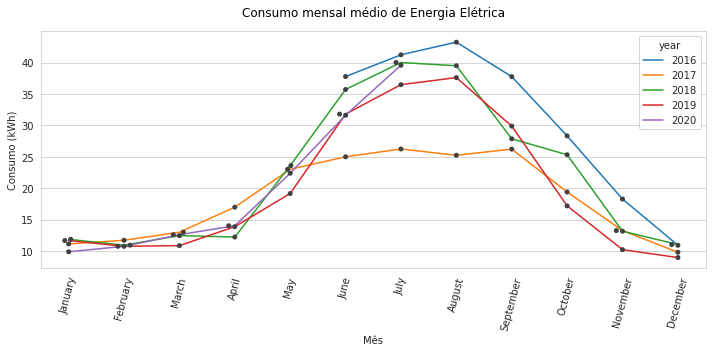

In [47]:
# Plot the responses for different events and regions
fig, axs = plt.subplots(figsize=(10,5))

ax = sns.lineplot(x="month", 
                  y="consumption", 
                  hue="year",  
                  #style='year',
                  #markers=True,
                  data=df_cons_year_mean)

ax = sns.swarmplot(x="month", y="consumption", data=df_cons_year_mean, color=".25")

ax.tick_params(axis='x',labelrotation=75)

# Define os nomes dos eixos x e Y
ax.set_ylabel('Consumo (kWh)')
ax.set_xlabel('Mês')

# Define o titulo do grafico
ax.set_title('Consumo mensal médio de Energia Elétrica', pad=15, color='black')

plt.tight_layout()

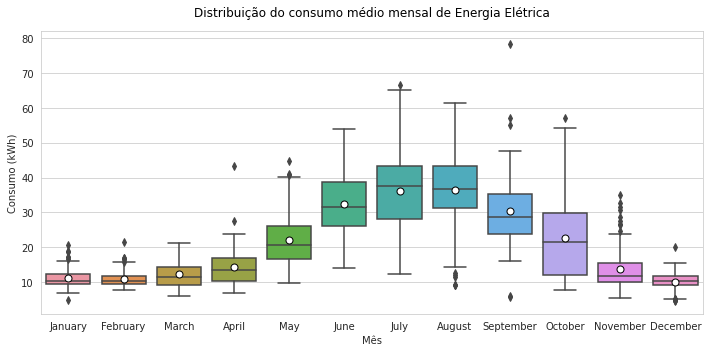

In [48]:
# Plot the responses for different events and regions
fig, axs = plt.subplots(figsize=(10,5))

ax = sns.boxplot(x="month", 
                 y="consumption", 
                 data=df_cons_pred,
                 showmeans=True, 
                 meanprops={"marker":"o",
                            "markerfacecolor":"white", 
                            "markeredgecolor":"black",
                            "markersize":"7"},
                 order=months)
#ax = sns.swarmplot(x="month", y="consumption", data=df_cons_year_mean, color=".25")

# Define os nomes dos eixos x e Y
ax.set_ylabel('Consumo (kWh)')
ax.set_xlabel('Mês')

# Define o titulo do grafico
ax.set_title('Distribuição do consumo médio mensal de Energia Elétrica', pad=15, color='black')

plt.tight_layout()

###Consumo semanal típico

In [49]:
#lista com os dias da semana ordenados cronologicamente
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 9.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 12.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 10.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 11.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 14.5% of the points cannot be placed; yo

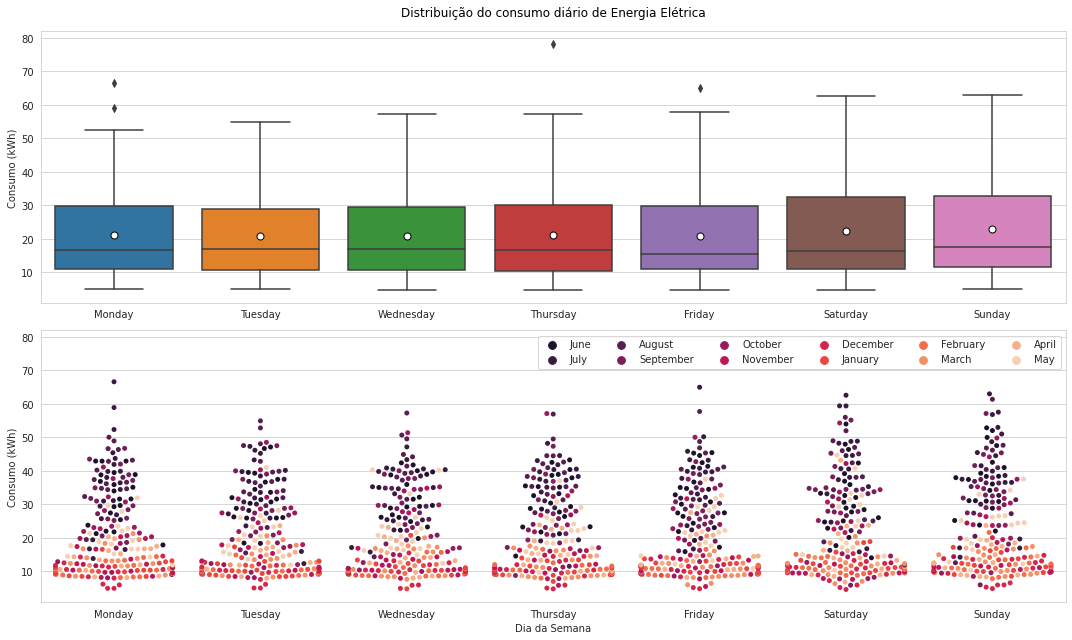

In [50]:
# Plot the responses for different events and regions
fig, axs = plt.subplots(2,figsize=(15,9))

ax = sns.boxplot(x="day_of_week", 
                 y="consumption", 
                 data=df_cons_pred, 
                 showmeans=True,
                 order = days_of_week,
                 meanprops={"marker":"o",
                            "markerfacecolor":"white", 
                            "markeredgecolor":"black",
                            "markersize":"7"},
                 ax=axs[0])

# Define o titulo do grafico
ax.set_title('Distribuição do consumo diário de Energia Elétrica', pad=15, color='black')
# Define o nome do eixo Y
ax.set_ylabel('Consumo (kWh)')
ax.set(xlabel=None)

ax = sns.swarmplot(x="day_of_week", 
                   y="consumption", 
                   data=df_cons_pred,
                   palette ="rocket",                  
                   hue='month',
                   order=days_of_week,
                   ax=axs[1])

# Define os nomes dos eixos x e Y
ax.set_ylabel('Consumo (kWh)')
ax.set_xlabel('Dia da Semana')
plt.legend(loc='upper right', ncol=6)# bbox_to_anchor=(1, 1))

plt.tight_layout()

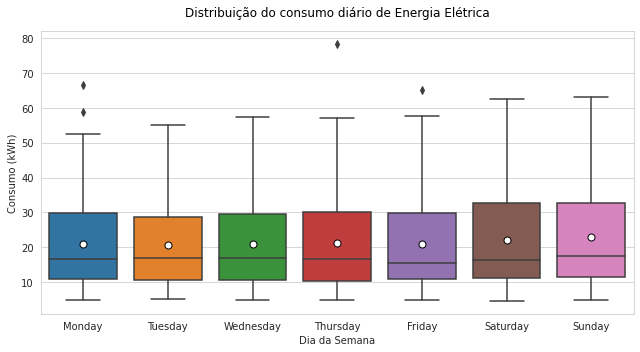

In [51]:
# Plot the responses for different events and regions
fig, axs = plt.subplots(figsize=(9,5))

ax = sns.boxplot(x="day_of_week", 
                 y="consumption", 
                 data=df_cons_pred, 
                 showmeans=True,
                 order = days_of_week,
                 meanprops={"marker":"o",
                            "markerfacecolor":"white", 
                            "markeredgecolor":"black",
                            "markersize":"7"})

# Define os nomes dos eixos x e Y
ax.set_ylabel('Consumo (kWh)')
ax.set_xlabel('Dia da Semana')

# Define o titulo do grafico
ax.set_title('Distribuição do consumo diário de Energia Elétrica', pad=15, color='black')

plt.tight_layout()

##Variáveis contínuas

###Analise boxplot

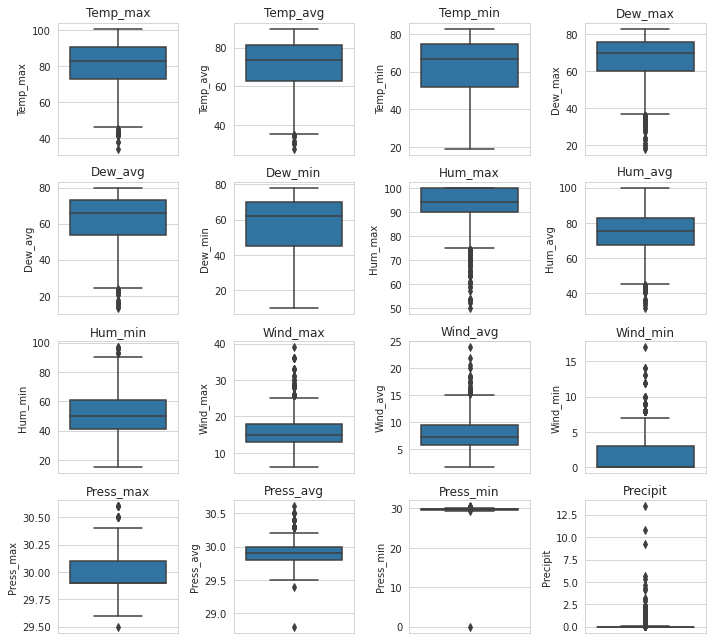

In [52]:
#Plot do histograma de cada coluna
n, m = 4, 4
fig, axs = plt.subplots(n, m,figsize=(10,9))
fig.tight_layout()
count = 0
for j in range(n):
  for i in range(m):
    #axs[j, i].boxplot(x=df_cons_pred[features_cont[count]])
    ax = sns.boxplot(y=df_cons_pred[features_cont[count]],ax=axs[j, i])
    axs[j, i].set_title(features_cont[count])
    plt.tight_layout()
    count +=1

In [53]:
for feature in features_cont:
  filtro_upper = df_cons_pred[feature]> (df_cons_pred[feature].mean() + 3*df_cons_pred[feature].std())
  filtro_lower = df_cons_pred[feature]< (df_cons_pred[feature].mean() - 3*df_cons_pred[feature].std())
  index_drop = df_cons_pred.loc[filtro_upper | filtro_lower].index
  df_cons_pred.drop(index= index_drop, inplace=True)

In [54]:
df_cons_pred.shape

(1388, 24)

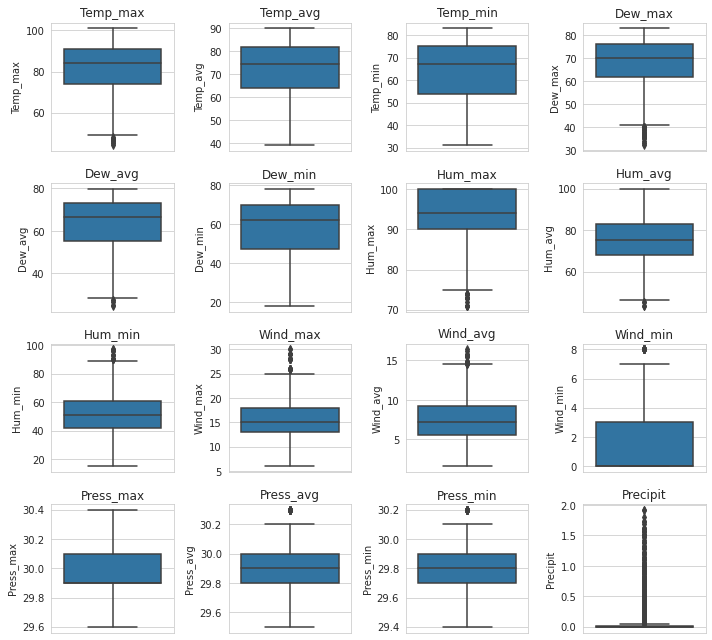

In [55]:
#Plot do histograma de cada coluna
n, m = 4, 4
fig, axs = plt.subplots(n, m,figsize=(10,9))
fig.tight_layout()
count = 0
for j in range(n):
  for i in range(m):
    #axs[j, i].boxplot(x=df_cons_pred[features_cont[count]])
    ax = sns.boxplot(y=df_cons_pred[features_cont[count]],ax=axs[j, i])
    axs[j, i].set_title(features_cont[count])
    plt.tight_layout()
    count +=1

In [56]:
df_cons_pred.describe()

,Temp_max,Temp_avg,Temp_min,Dew_max,Dew_avg,Dew_min,Hum_max,Hum_avg,Hum_min,Wind_max,Wind_avg,Wind_min,Press_max,Press_avg,Press_min,Precipit,consumption,vacation,lockdown
count,1388.000000,1388.000000,1388.000000,1388.000000,1388.000000,1388.000000,1388.000000,1388.000000,1388.000000,1388.000000,1388.000000,1388.000000,1388.000000,1388.000000,1388.000000,1388.000000,1388.000000,1388.000000,1388.000000
mean,81.710375,72.124856,63.613833,67.257205,62.836455,57.580692,93.425072,75.120965,51.692363,15.541787,7.503026,1.198847,29.967435,29.898271,29.827450,0.103919,21.773926,0.033141,0.067003
std,11.919266,11.685209,12.846019,10.965147,12.252014,13.986861,6.160390,10.759577,15.117651,4.474278,2.704762,2.187518,0.150625,0.144487,0.145552,0.286933,12.844332,0.179070,0.250117
min,44.000000,39.000000,31.000000,32.000000,24.700000,18.000000,71.000000,43.600000,15.000000,6.000000,1.600000,0.000000,29.600000,29.500000,29.400000,0.000000,4.610000,0.000000,0.000000
25%,74.000000,63.975000,53.750000,62.000000,55.075000,47.000000,90.000000,68.100000,42.000000,13.000000,5.600000,0.000000,29.900000,29.800000,29.700000,0.000000,10.790750,0.000000,0.000000
50%,84.000000,74.300000,67.000000,70.000000,66.400000,62.000000,94.000000,75.200000,51.000000,15.000000,7.200000,0.000000,29.900000,29.900000,29.800000,0.000000,17.081000,0.000000,0.000000
75%,91.000000,81.900000,75.000000,76.000000,73.225000,70.000000,100.000000,82.800000,61.000000,18.000000,9.200000,3.000000,30.100000,30.000000,29.900000,0.020000,31.480500,0.000000,0.000000
max,101.000000,90.000000,83.000000,83.000000,79.800000,78.000000,100.000000,99.900000,97.000000,30.000000,16.400000,8.000000,30.400000,30.300000,30.200000,1.920000,78.225300,1.000000,1.000000


###Analise correlação

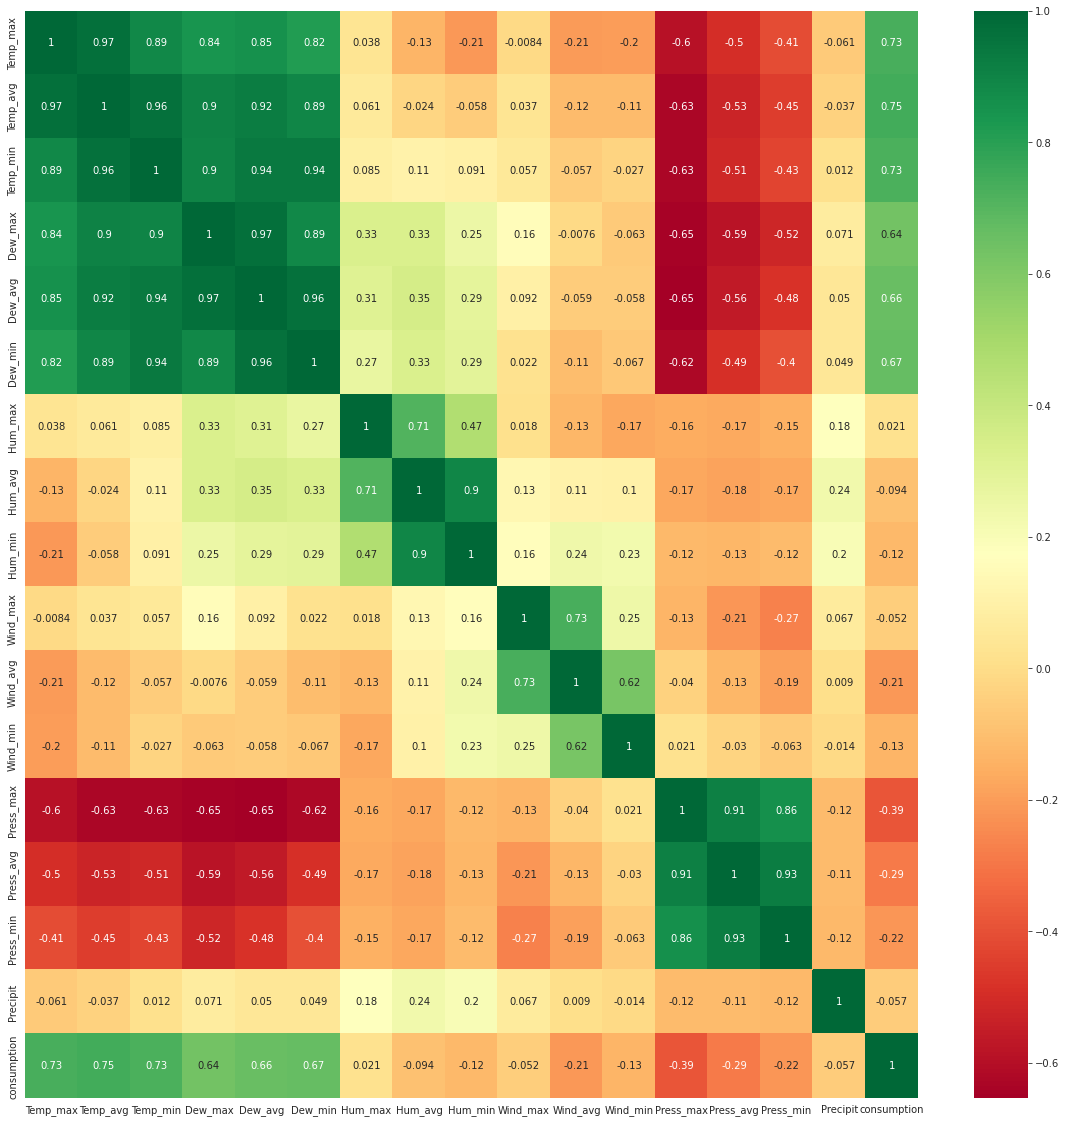

In [57]:
#correlacao linear
#get correlations of each features in dataset
corrmat = df_cons_pred[features_cont + ['consumption']].corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(df_cons_pred[top_corr_features].corr(),annot=True,cmap="RdYlGn")

###Analise de escala

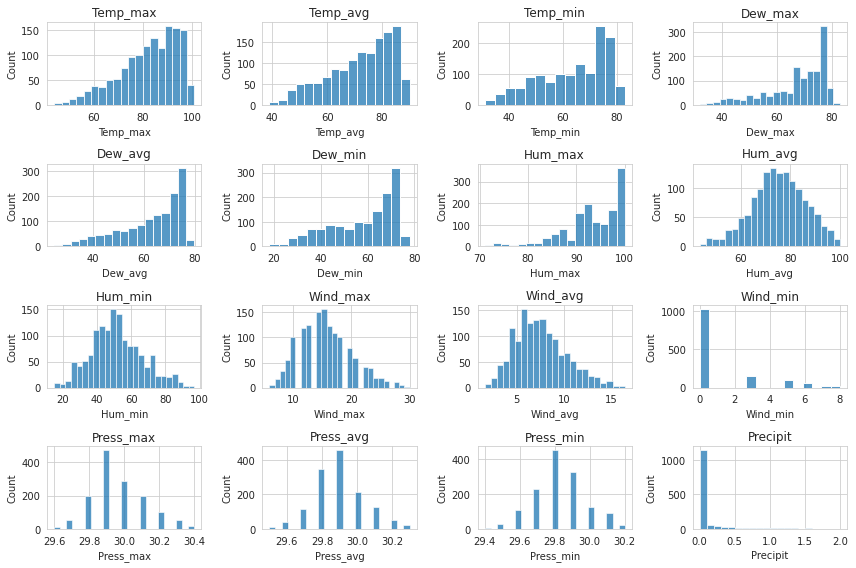

In [58]:
#Plot do histograma de cada coluna
n, m = 4, 4
fig, axs = plt.subplots(n, m,figsize=(12,8))
fig.tight_layout()
count = 0
for j in range(n):
  for i in range(m):
    if features_cont[count] != 'Precipit':
      ax = sns.histplot(x=df_cons_pred[features_cont[count]],ax=axs[j, i])
    else:
      ax = sns.histplot(x=df_cons_pred[features_cont[count]], binwidth=0.1, ax=axs[j, i])
    axs[j, i].set_title(features_cont[count])
    plt.tight_layout()
    count +=1

####Mudança de Escala

In [59]:
scaler = StandardScaler()

In [60]:
for feature in features_cont:
  temp = StandardScaler().fit_transform(df_cons_pred[feature].values.reshape(-1, 1))
  df_cons_pred[feature] = temp

####Escala logarítmica

In [61]:
feature_log = ['Wind_min', 'Precipit']

In [62]:
for feature in feature_log:
  df_cons_pred[feature + '_log'] = np.log10(df_cons_pred[feature] + 1)

In [63]:
df_cons_pred[['Precipit', 'Precipit_log', 'Wind_min', 'Wind_min_log']].describe()

,Precipit,Precipit_log,Wind_min,Wind_min_log
count,1.388000e+03,1388.000000,1.388000e+03,1388.000000
mean,1.059831e-16,-0.091705,7.342830e-17,-0.154052
std,1.000360e+00,0.228858,1.000360e+00,0.329019
min,-3.623039e-01,-0.195386,-5.482376e-01,-0.345090
25%,-3.623039e-01,-0.195386,-5.482376e-01,-0.345090
50%,-3.623039e-01,-0.195386,-5.482376e-01,-0.345090
75%,-2.925760e-01,-0.150320,8.236743e-01,0.260947
max,6.331577e+00,0.865197,3.110194e+00,0.613862


In [64]:
for feature in feature_log:
  features_cont.remove(feature)
  features_cont.append(feature+'_log')

In [65]:
features_cont

['Temp_max',
 'Temp_avg',
 'Temp_min',
 'Dew_max',
 'Dew_avg',
 'Dew_min',
 'Hum_max',
 'Hum_avg',
 'Hum_min',
 'Wind_max',
 'Wind_avg',
 'Press_max',
 'Press_avg',
 'Press_min',
 'Wind_min_log',
 'Precipit_log']

###Teste Anova

In [66]:
def last(n):
    return n[-1]  
   
def sort(tuples, order_reverse):
    return sorted(tuples, key=last, reverse=order_reverse)

In [67]:
# Avaliação das features aplicando Mutual Information
test = SelectKBest(score_func=mutual_info_regression, k='all')
fit = test.fit(df_cons_pred[features_cont], df_cons_pred['consumption'])

columns_scores_MI = [*zip(fit.get_feature_names_out(), fit.scores_)]

In [68]:
sort(columns_scores_MI, True)

[('Temp_avg', 0.7342332576854207),
 ('Temp_max', 0.68991963074803),
 ('Temp_min', 0.5402626239865045),
 ('Dew_avg', 0.46879653563637724),
 ('Dew_max', 0.45211504455516494),
 ('Dew_min', 0.4042045462919517),
 ('Press_max', 0.20300771974650278),
 ('Hum_min', 0.1551042080195275),
 ('Press_avg', 0.1537171172148346),
 ('Press_min', 0.1337947825915693),
 ('Hum_avg', 0.11371407622864016),
 ('Hum_max', 0.11160558538558352),
 ('Wind_avg', 0.059533427158064534),
 ('Wind_max', 0.05139349368228352),
 ('Precipit_log', 0.010598986987132353),
 ('Wind_min_log', 0.0018999698782233843)]

In [69]:
#print das features e seus respectivos p-value
columns_cont_select_MI = []
for column_value in columns_scores_MI:
  if column_value[1]>0.1:
    columns_cont_select_MI.append(column_value[0])

columns_cont_select_MI

['Temp_max',
 'Temp_avg',
 'Temp_min',
 'Dew_max',
 'Dew_avg',
 'Dew_min',
 'Hum_max',
 'Hum_avg',
 'Hum_min',
 'Press_max',
 'Press_avg',
 'Press_min']

In [70]:
# Avaliação das features aplicando o teste F
test = SelectKBest(score_func=f_regression, k='all')
fit = test.fit(df_cons_pred[features_cont], df_cons_pred['consumption'])

columns_scores_f = [*zip(fit.get_feature_names_out(), fit.pvalues_)]

In [71]:
sort(columns_scores_f, False)

[('Temp_avg', 7.61943007306409e-248),
 ('Temp_max', 1.2027131467917891e-235),
 ('Temp_min', 9.61685607511445e-228),
 ('Dew_min', 4.8555900425885845e-178),
 ('Dew_avg', 3.376469221814673e-176),
 ('Dew_max', 1.6771744319170795e-158),
 ('Press_max', 5.567877637036856e-51),
 ('Press_avg', 1.6564690947382093e-27),
 ('Press_min', 2.743220666651347e-16),
 ('Wind_avg', 1.2068195181125488e-15),
 ('Wind_min_log', 2.345316571152153e-06),
 ('Hum_min', 4.343432205700932e-06),
 ('Hum_avg', 0.00043845590805977904),
 ('Precipit_log', 0.0030342133938626075),
 ('Wind_max', 0.05329046743214113),
 ('Hum_max', 0.44308103481599914)]

In [72]:
#print das features e seus respectivos p-value
columns_cont_select_f = []
for column_value in columns_scores_f:
  if column_value[1]<0.05:
    columns_cont_select_f.append(column_value[0])

columns_cont_select_f

['Temp_max',
 'Temp_avg',
 'Temp_min',
 'Dew_max',
 'Dew_avg',
 'Dew_min',
 'Hum_avg',
 'Hum_min',
 'Wind_avg',
 'Press_max',
 'Press_avg',
 'Press_min',
 'Wind_min_log',
 'Precipit_log']

##Variáveis categóricas

###Analise de frequencia

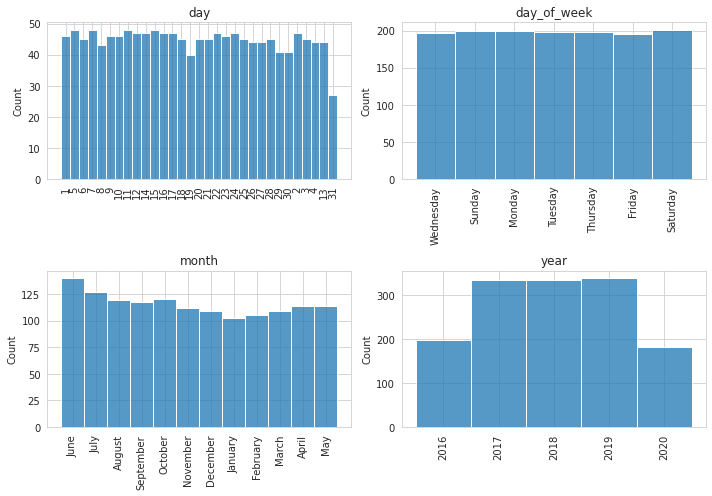

In [73]:
#Plot do histograma de cada coluna
n, m = 2, 2
fig, axs = plt.subplots(n, m,figsize=(10,7))
fig.tight_layout()
count = 0
features_cat_balance = ['day', 'day_of_week', 'month', 'year']
for j in range(n):
  for i in range(m):
    ax = sns.histplot(x=df_cons_pred[features_cat_balance[count]], ax=axs[j, i])
    axs[j, i].set_title(features_cat_balance[count])
    ax.tick_params(axis='x', labelrotation=90)
    ax.set(xlabel=None)
    plt.tight_layout()
    count +=1

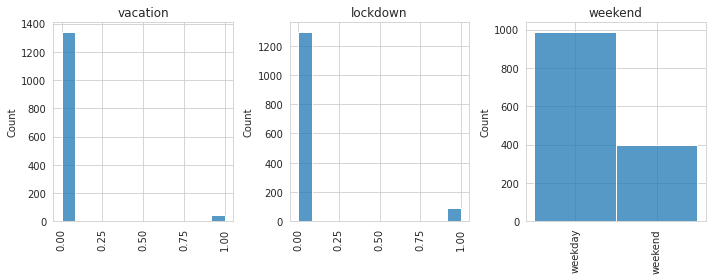

In [74]:
#Plot do histograma de cada coluna
n, m = 1, 3
fig, axs = plt.subplots(ncols=m,figsize=(10,4))
fig.tight_layout()

features_cat_disbalance = ['vacation', 'lockdown', 'weekend']

for j in range(m):
  ax = sns.histplot(x=df_cons_pred[features_cat_disbalance[j]], ax=axs[j])
  axs[j].set_title(features_cat_disbalance[j])
  ax.tick_params(axis='x', labelrotation=90)
  ax.set(xlabel=None)
  plt.tight_layout()

In [75]:
for feature in ['vacation', 'lockdown']:
  features_cat.remove(feature)
  df_cons_pred.drop(columns=feature, inplace=True)

In [76]:
columns_cat_select = features_cat
columns_cat_select

['day', 'weekend', 'day_of_week', 'month', 'year']

#Treinamento e Teste

##Feature Selection

In [77]:
X = df_cons_pred[columns_cont_select_f + columns_cat_select]
y = df_cons_pred.consumption

###One hot encoder + dummies

In [78]:
# Definindo a função Dummies
def dummies(x,df):
    
    #cria um dataframe temporario com o resultado do processo One-hot Encode e deletando a primeira coluna
    temp = pd.get_dummies(df[x], drop_first = True)
    
    #concatena o dataframe df com o temporario
    df = pd.concat([df, temp], axis = 1)
    
    #exclui a coluna referente ao atributo x
    df = df.drop(columns = x)
    
    return df

In [79]:
#aplica a função dummies para os atributos categoricos
for feature in columns_cat_select:
    X = dummies(feature,X)

In [80]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1388 entries, 0 to 1497
Data columns (total 65 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Temp_max      1388 non-null   float64
 1   Temp_avg      1388 non-null   float64
 2   Temp_min      1388 non-null   float64
 3   Dew_max       1388 non-null   float64
 4   Dew_avg       1388 non-null   float64
 5   Dew_min       1388 non-null   float64
 6   Hum_avg       1388 non-null   float64
 7   Hum_min       1388 non-null   float64
 8   Wind_avg      1388 non-null   float64
 9   Press_max     1388 non-null   float64
 10  Press_avg     1388 non-null   float64
 11  Press_min     1388 non-null   float64
 12  Wind_min_log  1388 non-null   float64
 13  Precipit_log  1388 non-null   float64
 14  10            1388 non-null   uint8  
 15  11            1388 non-null   uint8  
 16  12            1388 non-null   uint8  
 17  13            1388 non-null   uint8  
 18  14            1388 non-null 

##Preparação

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

##Modelos

###Regressão Linear

In [82]:
pcp_LM = LinearRegression()

In [83]:
pcp_LM.fit(X_train, y_train)

LinearRegression()

In [111]:
y_predict_LM = pcp_LM.predict(X_test)

###Random Forest Regressor

####Tuning hiperparametros

In [87]:
"""
# Conjunto de valores para os Hiperparametros
params = {
    "n_estimators": (1,1000),
    "max_depth": (1,50)
}"""

'\n# Conjunto de valores para os Hiperparametros\nparams = {\n    "n_estimators": (1,1000),\n    "max_depth": (1,50)\n}'

In [88]:
"""%%time
# Criação da class BayesSearchCV para os parametros escolhidos:
BS_RF = BayesSearchCV(estimator = RandomForestRegressor(),
                       search_spaces = params,
                       scoring='r2',
                       cv = 10,
                       n_iter = 20, 
                       random_state=123)

# Realizando a otimização por BayesSearchCV:
BS_RF.fit(X_test,y_test)"""

"%%time\n# Criação da class BayesSearchCV para os parametros escolhidos:\nBS_RF = BayesSearchCV(estimator = RandomForestRegressor(),\n                       search_spaces = params,\n                       scoring='r2',\n                       cv = 10,\n                       n_iter = 20, \n                       random_state=123)\n\n# Realizando a otimização por BayesSearchCV:\nBS_RF.fit(X_test,y_test)"

In [89]:
"""# Melhores valores para os paramentros:
BS_RF.best_params_"""

'# Melhores valores para os paramentros:\nBS_RF.best_params_'

####Treinamento, validação e teste

In [90]:
pcp_RFR = RandomForestRegressor(n_estimators= 185, max_depth=39)

In [91]:
pcp_RFR.fit(X_train, y_train)

RandomForestRegressor(max_depth=39, n_estimators=185)

In [112]:
y_predict_RFR = pcp_RFR.predict(X_test)

###Support Vector Machines Regression

In [93]:
from sklearn.svm import SVR

#####Tuning hiperparametros

In [94]:
"""
# Conjunto de valores para os Hiperparametros
params = {
          'C': (1e-3, 1e+3, 'log-uniform'),
          #'gamma': (1e-2, 1e+1, 'log-uniform'),
          #'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
         }"""

"\n# Conjunto de valores para os Hiperparametros\nparams = {\n          'C': (1e-3, 1e+3, 'log-uniform'),\n          #'gamma': (1e-2, 1e+1, 'log-uniform'),\n          #'kernel': ['linear', 'poly', 'rbf', 'sigmoid']\n         }"

In [95]:
"""%%time
# Criação da class BayesSearchCV para os parametros escolhidos e tendo o recall como metrica de avaliacao:
BS_SVR = BayesSearchCV(estimator = SVR(),
                       search_spaces = params,
                       scoring='r2',
                       cv = 10,
                       n_iter = 20, 
                       random_state=123)

# Realizando a otimização por BayesSearchCV para a deteccao de curto circuito:
BS_SVR.fit(X_test,y_test)"""

"%%time\n# Criação da class BayesSearchCV para os parametros escolhidos e tendo o recall como metrica de avaliacao:\nBS_SVR = BayesSearchCV(estimator = SVR(),\n                       search_spaces = params,\n                       scoring='r2',\n                       cv = 10,\n                       n_iter = 20, \n                       random_state=123)\n\n# Realizando a otimização por BayesSearchCV para a deteccao de curto circuito:\nBS_SVR.fit(X_test,y_test)"

In [96]:
"""
BS_SVR.best_params_
"""

'\nBS_SVR.best_params_\n'

#####Treinamento, validação e teste

In [97]:
pcp_SVM = SVR(C = 16.32 )

In [98]:
pcp_SVM.fit(X_train, y_train)

SVR(C=16.32)

In [113]:
y_predict_SVM = pcp_SVM.predict(X_test)

###XGBoost Classifier

In [100]:
from xgboost import XGBRegressor

#####Tuning hiperparametros

In [101]:
"""
# Conjunto de valores para os Hiperparametros
params = {
    "eta": (0,1),
    "gamma": (0, 200),
    "max_depth": (1, 100),
    'n_estimators':(1,5000),
}
"""

'\n# Conjunto de valores para os Hiperparametros\nparams = {\n    "eta": (0,1),\n    "gamma": (0, 200),\n    "max_depth": (1, 100),\n    \'n_estimators\':(1,5000),\n}\n'

In [102]:
"""
%time
# Criação da class BayesSearchCV para os parametros escolhidos e tendo o recall como metrica de avaliacao:
BS_XGB = BayesSearchCV(estimator = XGBRegressor(),
                       search_spaces = params,
                       scoring='r2',
                       cv = 10,
                       n_iter = 20, 
                       random_state=123)

# Realizando a otimização por BayesSearchCV para a deteccao de curto circuito:
BS_XGB.fit(X_test,y_test)
"""

"\n%time\n# Criação da class BayesSearchCV para os parametros escolhidos e tendo o recall como metrica de avaliacao:\nBS_XGB = BayesSearchCV(estimator = XGBRegressor(),\n                       search_spaces = params,\n                       scoring='r2',\n                       cv = 10,\n                       n_iter = 20, \n                       random_state=123)\n\n# Realizando a otimização por BayesSearchCV para a deteccao de curto circuito:\nBS_XGB.fit(X_test,y_test)\n"

In [103]:
"""
# Melhores valores para os paramentros:
print('Best param: {}'.format(BS_XGB.best_params_))

print('Best Score: {}'.format(BS_XGB.best_score_))
"""

"\n# Melhores valores para os paramentros:\nprint('Best param: {}'.format(BS_XGB.best_params_))\n\nprint('Best Score: {}'.format(BS_XGB.best_score_))\n"

#####Treinamento, validacao e teste

In [104]:
pcp_XGB = XGBRegressor()#eta=0, gamma=117, max_depth=66, n_estimators=1472)

In [105]:
pcp_XGB.fit(X_train, y_train)

[23:05:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [114]:
y_predict_XGB = pcp_XGB.predict(X_test)

###LGBM Regressor

In [220]:
from lightgbm import LGBMRegressor

#####Tuning hiperparametros

In [245]:
"""
# Conjunto de valores para os Hiperparametros
params = {
    "num_leaves ": (1,50)
}


In [246]:
"""
%%time
# Criação da class BayesSearchCV para os parametros escolhidos e tendo o recall como metrica de avaliacao:
BS_XGB = BayesSearchCV(estimator = LGBMRegressor(),
                       search_spaces = params,
                       scoring='r2',
                       cv = 10,
                       n_iter = 20, 
                       random_state=123)

# Realizando a otimização por BayesSearchCV para a deteccao de curto circuito:
BS_XGB.fit(X_test,y_test)
"""

CPU times: user 13.6 s, sys: 4.94 s, total: 18.5 s
Wall time: 13.6 s


In [247]:
"""
# Melhores valores para os paramentros:
print('Best param: {}'.format(BS_XGB.best_params_))

print('Best Score: {}'.format(BS_XGB.best_score_))
"""

Best param: OrderedDict([('max_depth', 2), ('num_leaves ', 50)])
Best Score: 0.74386786632296


#####Treinamento, validacao e teste

In [263]:
pcp_LGBM = LGBMRegressor(num_leaves=43)

In [264]:
pcp_LGBM.fit(X_train, y_train)

LGBMRegressor(num_leaves=43)

In [265]:
pcp_LGBM.score(X_test, y_test)

0.795472249600887

In [223]:
y_predict_LGBM = pcp_LGBM.predict(X_test)

#Analise dos modelos

In [224]:
modelos = ['LM', 'RFR', 'SVM', 'XGB', 'LGBM']

In [225]:
results = pd.DataFrame(columns=['Modelo', 'r2_score', 'MAPE', 'MSE', 'RMSE'])

In [226]:
results.Modelo = modelos

In [227]:
def metric(metrica, model):
  
  if metrica != 'RMSE':
    fn = globals()[metrica]
    return fn(y_test, globals()["y_predict_"+ str(model)])
  
  elif metrica == 'RMSE':
    return MSE(y_test, globals()["y_predict_"+ str(model)], squared=False)

In [228]:
for column in results.columns[1:]:
  metrica = []
  for model in modelos:
    metrica.append(metric(column, model))
  results[column] = metrica

In [229]:
results

,Modelo,r2_score,MAPE,MSE,RMSE
0,LM,0.712272,0.297950,49.681160,7.048486
1,RFR,0.788775,0.208300,36.471655,6.039177
2,SVM,0.796584,0.209107,35.123273,5.926489
3,XGB,0.804366,0.199304,33.779622,5.812024
4,LGBM,0.795472,0.204139,35.315266,5.942665


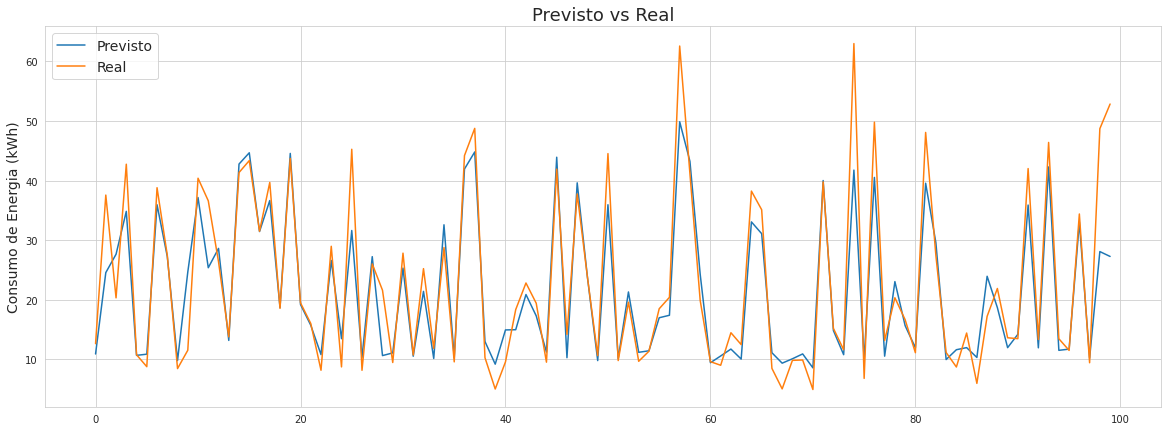

In [273]:
#Gerando gráfico comparativo entre a curva real e a curva prevista
x = list(range(100))
plt.figure(figsize=(20,7))
plt.plot(x, y_predict_XGB[:100], x, y_test[:100])
plt.title('Previsto vs Real', fontsize=18)
plt.ylabel('Consumo de Energia (kWh)', fontsize=14)
plt.legend(['Previsto', 'Real'], loc='upper left', fontsize=14)

plt.show()

In [272]:
y_predict_XGB[100]

43.242016

In [276]:
y_test.index

Int64Index([ 333, 1082, 1407,  107,  609, 1233,  740, 1211,  244,  428,
            ...
             827,  311,  763,  845, 1192,  285, 1314,   87, 1015,  335],
           dtype='int64', length=347)